## Setup


In [1]:
import datetime
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.3.1


# LOAD GPU

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Load the data: the fruits datasets

In [3]:
Train_Images = './input/fruits_360/Train'
Validation_Images = './input/fruits_360/Validation'

### Filter out corrupted images
in real-world data, corrupted images are common. we filter out badly-encoded images that do not feature the string "JFIF"in their header.

In [4]:
def cleaner(ID):
    
    directory_list =[x[0] for x in os.walk(ID)]
    num_skipped = 0
    
    # you may need to restart script if throws error after an initial pop
    directory_list.pop(0)
    for folder in directory_list:
        for fname in os.listdir(folder):
            fpath = os.path.join(folder, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)

    return "Deleted %d images" % num_skipped

In [5]:
# Note that this only deletes corrupted images and WILL NOT 
# inherit folder path so use the same folder path defined above to 
# generate dataset below
train_clean = cleaner(Train_Images)
val_clean = cleaner(Validation_Images)

## Generate a `Dataset`


In [6]:
image_size = (100, 100)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    Train_Images,
    validation_split=None,
    subset=None,
    seed=None,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    Validation_Images,
    validation_split=None,
    subset=None,
    seed=None,
    image_size=image_size,
    batch_size=batch_size,
)

Found 67692 files belonging to 131 classes.
Found 22688 files belonging to 131 classes.


### Assigning Class names from `train_dataset` to a list

In [7]:

class_names = train_ds.class_names
print('Total number of classes: ' + str(len(class_names)) + "\n")
print(class_names)

Total number of classes: 131

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 100, 100, 3)
(32,)


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


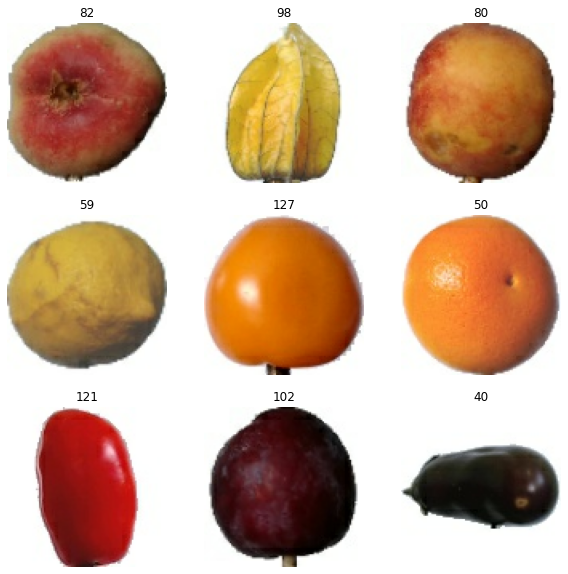

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build a model

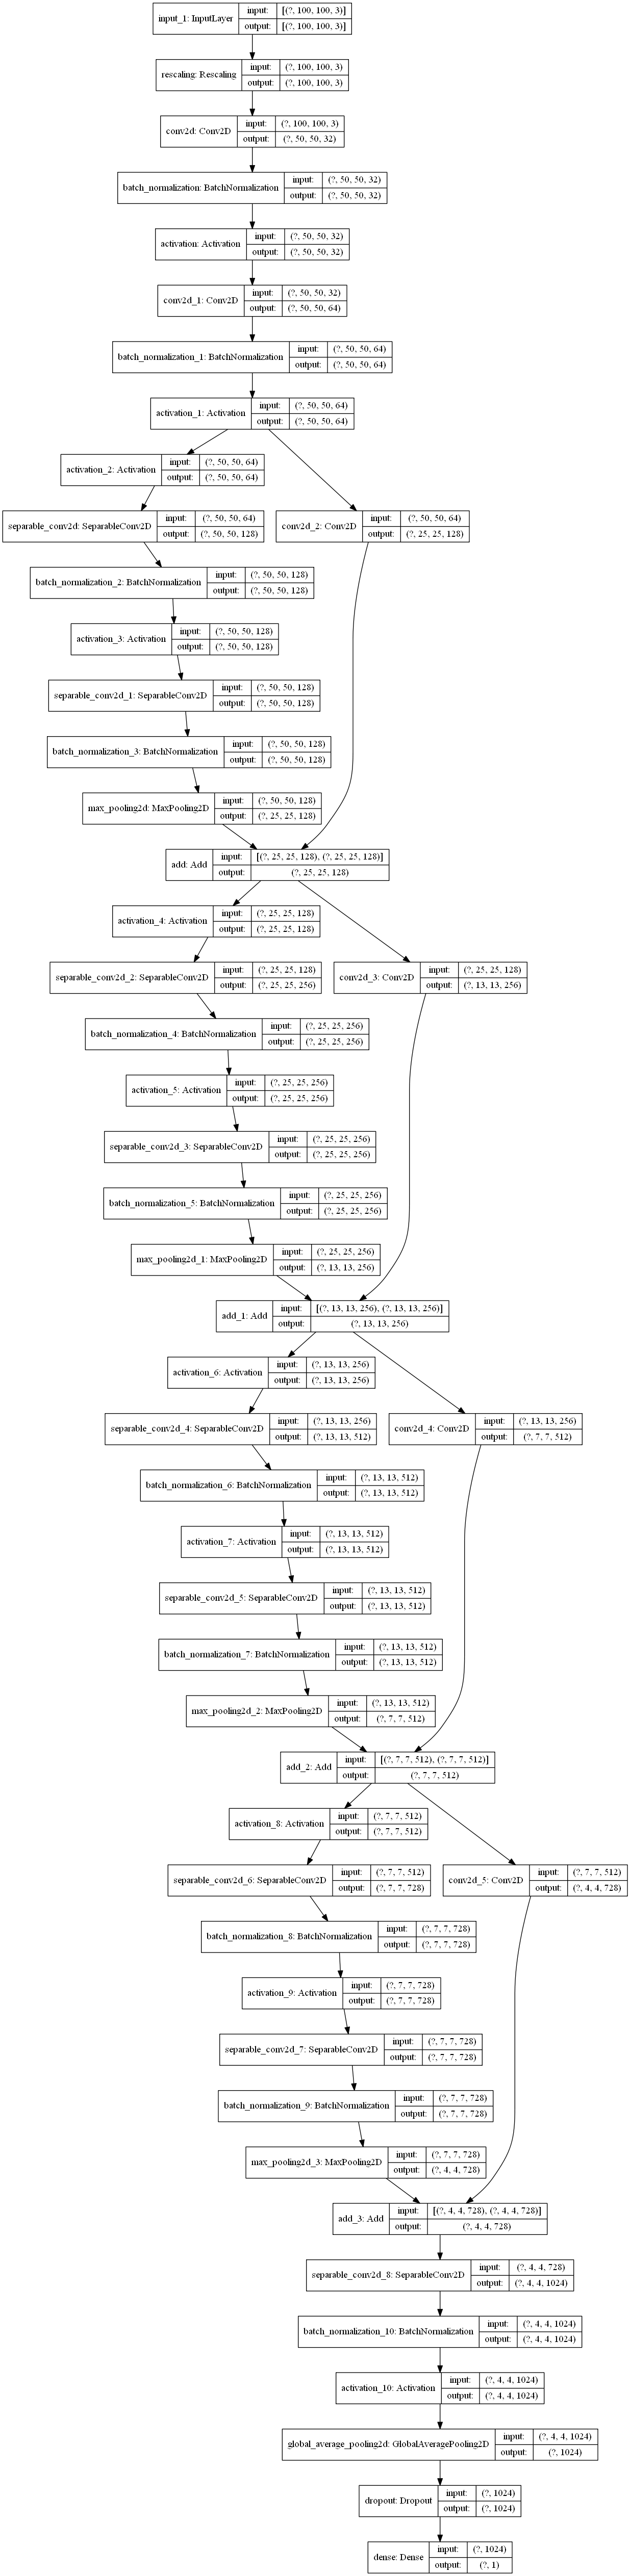

In [11]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block if you have low data count
    #x = data_augmentation(inputs)
    x = inputs

    # Entry block
    # standardize values to [0, 1] with a "Rescaling" layer at start of model.
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [12]:
epochs = 10

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/10
2116/2116 [==============================] - 357s 169ms/step - loss: 7.8913e-06 - accuracy: 0.0074 - val_loss: 7.8935e-06 - val_accuracy: 0.0065
Epoch 2/10
2116/2116 [==============================] - 405s 192ms/step - loss: 7.8913e-06 - accuracy: 0.0071 - val_loss: 7.8935e-06 - val_accuracy: 0.0065
Epoch 3/10
2116/2116 [==============================] - 411s 194ms/step - loss: 7.8913e-06 - accuracy: 0.0072 - val_loss: 7.8935e-06 - val_accuracy: 0.0065
Epoch 4/10
2116/2116 [==============================] - 414s 196ms/step - loss: 7.8913e-06 - accuracy: 0.0073 - val_loss: 7.8935e-06 - val_accuracy: 0.0065
Epoch 5/10
2116/2116 [==============================] - 419s 198ms/step - loss: 7.8913e-06 - accuracy: 0.0074 - val_loss: 7.8935e-06 - val_accuracy: 0.0065
Epoch 6/10
2116/2116 [==============================] - 421s 199ms/step - loss: 7.8913e-06 - accuracy: 0.0072 - val_loss: 7.8935e-06 - val_accuracy: 0.0065
Epoch 7/10
2116/2116 [==============================] - 423s 200

## Visualize model training results

In [13]:
# store history log as a dataframe to make plots
metrics = pd.DataFrame(history.history)

In [14]:
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.000008,0.007445,0.000008,0.006523
1,0.000008,0.007091,0.000008,0.006523
2,0.000008,0.007165,0.000008,0.006523
3,0.000008,0.007268,0.000008,0.006523
4,0.000008,0.007357,0.000008,0.006523


Text(0.5, 1.0, 'Training and Validation Loss')

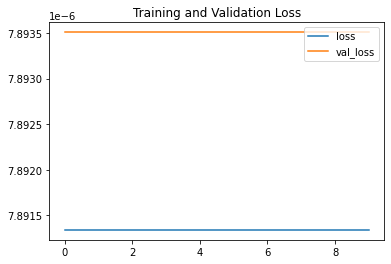

In [15]:
#plt.figure(figsize=(8, 8))
metrics[["loss","val_loss"]].plot()
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

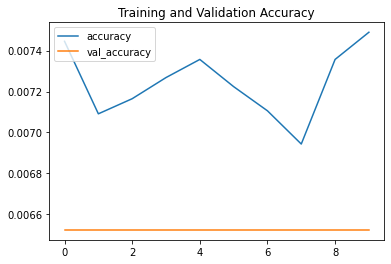

In [16]:
#plt.figure(figsize=(8, 8))
metrics[["accuracy","val_accuracy"]].plot()
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

## Run inference on new data

In [17]:
img = keras.preprocessing.image.load_img(
    './input/frut.jpg', target_size=(image_size)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This item is most likely a(n)... {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This item is most likely a(n)... Apple Braeburn with a 100.00 percent confidence.
